In [26]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import xgboost as xgb
from sklearn.metrics import mean_squared_error, mean_squared_log_error
from sklearn.preprocessing import LabelEncoder

In [2]:
train = pd.read_csv('data/train_merged.csv', parse_dates=['date'], low_memory=False)
test = pd.read_csv('data/test_merged.csv', parse_dates=['date'], low_memory=False)

In [3]:
train.earthquake.fillna('', inplace=True)
train.event_name.fillna('', inplace=True)
train.national_holiday.fillna('', inplace=True)
train.regional_holiday.fillna('', inplace=True)
train.local_holiday.fillna('', inplace=True)
train.work_day_name.fillna('', inplace=True)

test.earthquake.fillna('', inplace=True)
test.event_name.fillna('', inplace=True)
test.national_holiday.fillna('', inplace=True)
test.regional_holiday.fillna('', inplace=True)
test.local_holiday.fillna('', inplace=True)
test.work_day_name.fillna('', inplace=True)

In [4]:
train.head()

,id,date,store_nbr,family,sales,onpromotion,city,state,type,cluster,...,earthquake,event_name,national_holiday,regional_holiday,local_holiday,year,month,day,day_of_week,payday
0,0,2013-01-01,1,AUTOMOTIVE,0.0,0,Quito,Pichincha,D,13,...,,,Primer dia del ano,,,2013,1,1,1,False
1,1,2013-01-01,1,BABY CARE,0.0,0,Quito,Pichincha,D,13,...,,,Primer dia del ano,,,2013,1,1,1,False
2,2,2013-01-01,1,BEAUTY,0.0,0,Quito,Pichincha,D,13,...,,,Primer dia del ano,,,2013,1,1,1,False
3,3,2013-01-01,1,BEVERAGES,0.0,0,Quito,Pichincha,D,13,...,,,Primer dia del ano,,,2013,1,1,1,False
4,4,2013-01-01,1,BOOKS,0.0,0,Quito,Pichincha,D,13,...,,,Primer dia del ano,,,2013,1,1,1,False


In [5]:
test.head()

,id,date,store_nbr,family,onpromotion,city,state,type,cluster,transactions,...,earthquake,event_name,national_holiday,regional_holiday,local_holiday,year,month,day,day_of_week,payday
0,3000888,2017-08-16,1,AUTOMOTIVE,0,Quito,Pichincha,D,13,NaN,...,,,,,,2017,8,16,2,False
1,3000889,2017-08-16,1,BABY CARE,0,Quito,Pichincha,D,13,NaN,...,,,,,,2017,8,16,2,False
2,3000890,2017-08-16,1,BEAUTY,2,Quito,Pichincha,D,13,NaN,...,,,,,,2017,8,16,2,False
3,3000891,2017-08-16,1,BEVERAGES,20,Quito,Pichincha,D,13,NaN,...,,,,,,2017,8,16,2,False
4,3000892,2017-08-16,1,BOOKS,0,Quito,Pichincha,D,13,NaN,...,,,,,,2017,8,16,2,False


In [6]:
%%time
cat_features = [
    'family', 'store_nbr', 'city', 'state', 'cluster',
    'earthquake', 'event_name', 'national_holiday', 'regional_holiday', 'local_holiday', 
    'payday', 'type', 'work_day_name',
]
for name in cat_features:
    print(f'Encode {name}')
    le = LabelEncoder()
    le.fit(train[name].unique())
    train[name] = le.transform(train[name])
    test[name] = le.transform(test[name])

Encode family
Encode store_nbr
Encode city
Encode state
Encode cluster
Encode earthquake
Encode event_name
Encode national_holiday
Encode regional_holiday
Encode local_holiday
Encode payday
Encode type
Encode work_day_name
Wall time: 4.98 s


In [7]:
dates = sorted(train.date.unique())
border_date = dates[-30]
train_data = train[train.date <= border_date]
valid_data = train[train.date > border_date]

print(train_data.shape)
print(valid_data.shape)

(2949210, 23)
(51678, 23)


In [8]:
train_dates = train_data.date.unique()
valid_dates = valid_data.date.unique()
print(f'Train from {train_dates[0]} to {train_dates[-1]}')
print(f'Valid from {valid_dates[0]} to {valid_dates[-1]}')

Train from 2013-01-01T00:00:00.000000000 to 2017-07-17T00:00:00.000000000
Valid from 2017-07-18T00:00:00.000000000 to 2017-08-15T00:00:00.000000000


In [9]:
y_train = np.log(train_data[['sales']].values + 1)
y_valid = np.log(valid_data[['sales']].values + 1)

X_train = train_data.drop(['id', 'sales', 'year', 'date', 'transactions'], axis=1)
X_valid = valid_data.drop(['id', 'sales', 'year', 'date', 'transactions'], axis=1)

X_test = test.drop(['id', 'date', 'year', 'transactions'], axis=1)

In [10]:
X_test.head()

,store_nbr,family,onpromotion,city,state,type,cluster,oil_price,work_day_name,earthquake,event_name,national_holiday,regional_holiday,local_holiday,month,day,day_of_week,payday
0,0,0,0,18,12,3,12,46.8,0,0,0,0,0,0,8,16,2,0
1,0,1,0,18,12,3,12,46.8,0,0,0,0,0,0,8,16,2,0
2,0,2,2,18,12,3,12,46.8,0,0,0,0,0,0,8,16,2,0
3,0,3,20,18,12,3,12,46.8,0,0,0,0,0,0,8,16,2,0
4,0,4,0,18,12,3,12,46.8,0,0,0,0,0,0,8,16,2,0


In [11]:
xgb_params = {
    'gpu_id': 0,
    'tree_method': 'gpu_hist',
    'predictor': 'cpu_predictor',
    'use_rmm': True,
    'objective': 'reg:squarederror',
    'eval_metric': 'rmse',
    'random_state': 1,
    'learning_rate': 0.01,
    'subsample': 1,
    'max_depth': 7,
    'colsample_bytree': 1,
    'reg_alpha': 10,
    'reg_lambda': 1,
    'min_child_weight': 1,
}

In [12]:
%%time
xgb_train = xgb.DMatrix(X_train, label=y_train)
xgb_valid = xgb.DMatrix(X_valid, label=y_valid)
eval_list = [(xgb_train, 'train'), (xgb_valid, 'eval')]
eval_result = dict()

model = xgb.train(
    params=xgb_params,
    dtrain=xgb_train,
    evals=eval_list,
    evals_result=eval_result,
    num_boost_round=10000,
    early_stopping_rounds=100,
    verbose_eval=False,
)

Wall time: 1min 42s


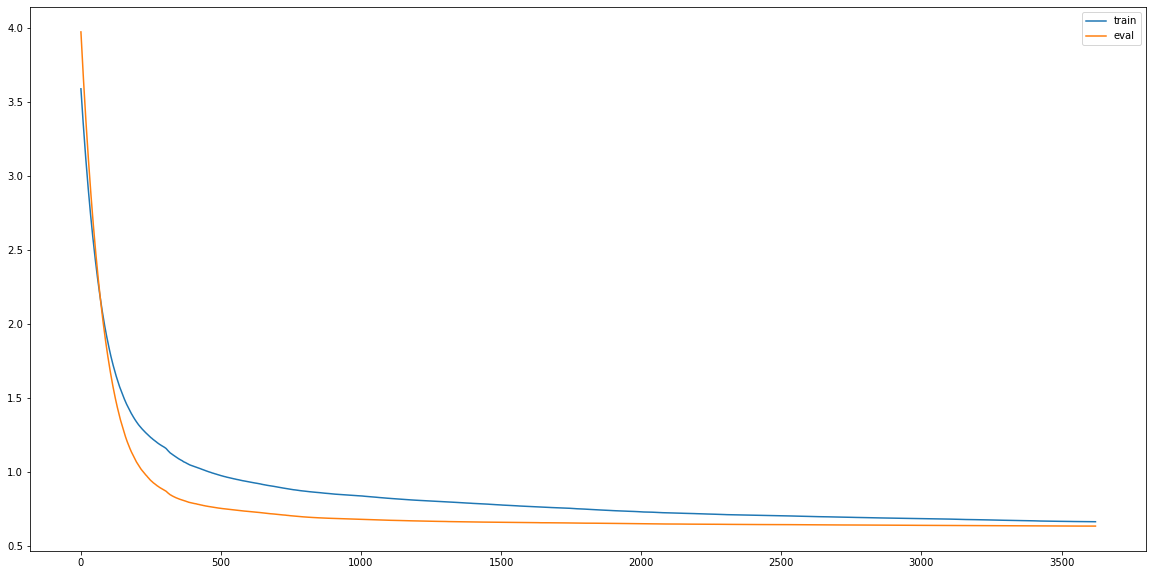

In [13]:
fig, ax = plt.subplots(figsize=(20, 10))
x = list(range(len(eval_result['eval']['rmse'])))
ax.plot(x, eval_result['train']['rmse'], label='train')
ax.plot(x, eval_result['eval']['rmse'], label='eval')
ax.legend(loc='upper right')
plt.show()

In [14]:
xgb_valid_pred = pd.Series(model.predict(xgb_valid)).map(lambda x: max(x, 0))
mean_squared_error(y_valid, xgb_valid_pred, squared=False)

0.6297938492232992

In [29]:
valid_pred = valid_data.copy().reset_index()
valid_pred['sales_pred'] = np.exp(xgb_valid_pred) - 1
valid_pred.groupby('family').apply(lambda x: mean_squared_log_error(x.sales, x.sales_pred))

family
0     0.393879
1     0.093251
2     0.343529
3     0.088718
4     0.036797
5     0.538907
6     0.504605
7     0.121506
8     0.050385
9     0.063067
10    0.764949
11    0.199018
12    0.057420
13    0.752143
14    0.370839
15    0.334668
16    0.351570
17    0.191262
18    0.072998
19    0.665420
20    1.022462
21    0.647645
22    0.390308
23    0.588179
24    0.808965
25    0.071624
26    0.561167
27    0.550773
28    0.712391
29    0.670491
30    0.099986
31    0.541267
32    0.428940
dtype: float64

In [30]:
full_data_products = []
for store_nbr in valid_pred.store_nbr.unique():
    for family in valid_pred.family.unique():
        cur_x = valid_pred[(valid_pred.store_nbr == store_nbr) & (valid_pred.family == family)]
        if cur_x.sales.any():
            full_data_products.append(cur_x)

In [31]:
len(full_data_products)

1670

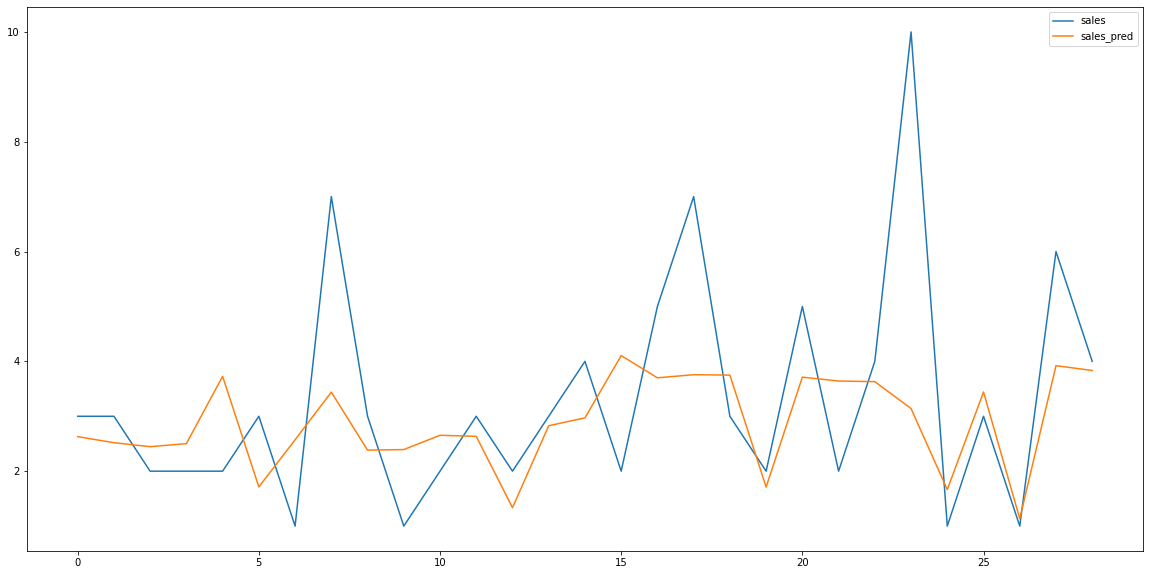

In [32]:
fig, ax = plt.subplots(figsize=(20, 10))
product = full_data_products[1]
X = list(range(0, len(product.sales)))
ax.plot(X, product.sales.values, label='sales')
ax.plot(X, product.sales_pred.values, label='sales_pred')
plt.legend(loc='upper right')
plt.show()

In [16]:
sorted(model.get_fscore().items(), key=lambda x: x[1], reverse=True)

[('family', 145567.0),
 ('store_nbr', 66139.0),
 ('oil_price', 54359.0),
 ('month', 30299.0),
 ('onpromotion', 24754.0),
 ('cluster', 22346.0),
 ('day_of_week', 17352.0),
 ('type', 17116.0),
 ('city', 16413.0),
 ('state', 12965.0),
 ('day', 10559.0),
 ('national_holiday', 8036.0),
 ('earthquake', 2507.0),
 ('event_name', 2031.0),
 ('work_day_name', 472.0),
 ('local_holiday', 472.0),
 ('payday', 311.0),
 ('regional_holiday', 19.0)]

In [33]:
xgb_test = xgb.DMatrix(X_test)
xgb_pred = np.exp(pd.Series(model.predict(xgb_test)).map(lambda x: max(x, 0))) - 1

In [34]:
pred = X_test.copy()
pred['sales'] = xgb_pred
pred.head()

,store_nbr,family,onpromotion,city,state,type,cluster,oil_price,work_day_name,earthquake,event_name,national_holiday,regional_holiday,local_holiday,month,day,day_of_week,payday,sales
0,0,0,0,18,12,3,12,46.8,0,0,0,0,0,0,8,16,2,0,3.465483
1,0,1,0,18,12,3,12,46.8,0,0,0,0,0,0,8,16,2,0,0.016967
2,0,2,2,18,12,3,12,46.8,0,0,0,0,0,0,8,16,2,0,5.332697
3,0,3,20,18,12,3,12,46.8,0,0,0,0,0,0,8,16,2,0,2549.932964
4,0,4,0,18,12,3,12,46.8,0,0,0,0,0,0,8,16,2,0,0.075719


In [35]:
for store_nbr in train.store_nbr.unique():
    for family in train.family.unique():
        cur_x = train[(train.store_nbr == store_nbr) & (train.family == family)]
        if not cur_x.sales.any():
            pred.loc[(pred.store_nbr == store_nbr) & (pred.family == family), 'sales'] = 0.0

In [36]:
sub = test[['id']].copy()
sub['sales'] = pred.sales
sub.head()

,id,sales
0,3000888,3.465483
1,3000889,0.000000
2,3000890,5.332697
3,3000891,2549.932964
4,3000892,0.075719


In [37]:
sub.to_csv('data/submission.csv', index=False)